In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:100% !important;}</style>"))

In [2]:
# section1, 2 で実装したもので必要なもの
from maze import MazeEnv
from agents import Agent
from policies import Policy

# 3. 方策最適化に基づく学習アルゴリズム
価値ベースの方法は、「行動空間」`Env.action_space` が巨大すぎる場合などではトレーニングに失敗することがあります。別の選択肢の 1 つは、値 Q(s,a) ではなく、ポリシー $\pi$ 自体のモデルを作成することです。

## 3-1. 状態価値関数、期待収益、方策勾配法
[Section2](https://github.com/AkinoriTanaka-phys/HPC-Phys_tutorial_and_hands-on/blob/master/section2.ipynb)
では行動価値関数を

$$
Q^\pi(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

としました。これは状態 s で行動 a を取った時の収益の期待値だったわけですが、これを更に a について方策で期待値を取ったもの

$$
V^{\pi}(s) = \langle Q^{\pi}(s, a) \rangle_{a \sim \pi(\cdot|s)}
$$

これは「方策 $\pi$ のもとで状態 s が持っている価値」を表し、**状態価値関数(state value function)** と呼ばれます。更に、迷路の実装を思い出すと

In [7]:
Env = MazeEnv(5,5, figsize=3)

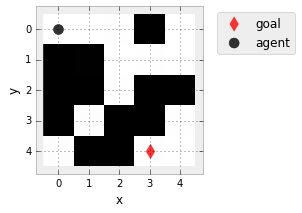

In [11]:
Env.reset()
Env.render()

の**`Env.reset()`**は最初の状態 s をランダムに選んでいるのがわかります。この確率を $P_\text{reset}(s)$ とし、状態価値の期待値を取ると

$$
J(\pi) = \langle V^{\pi}(s) \rangle_{s \sim P_\text{reset} (\cdot)}
$$

となりますが、環境が固定されている以上この量は「方策にしか依存しない量」であり、かつ方策の良さを表す量（大きいほど良い）であると言えるでしょう。これを**期待収益(expected return)**といいます。

### ● 方策勾配法
そこで、価値の推定をすっ飛ばして、この$J(\pi)$を直接最大化する学習が考えられます。そのうちでも最も単純なのが
方策を θ でパラメーター化し

$$
\pi(a|s) = \pi_\theta(a|s)
$$

この時の期待収益を $\theta$ の関数と考え、勾配更新

$$
\theta \leftarrow \theta + \eta \nabla_\theta J(\pi_{\theta})
$$

によって学習を進めてゆくことです。これを**方策勾配法(Policy-gradient method)**といいます。

問題は方策勾配 $\nabla_\theta J(\pi_{\theta})$ をどうやって求めるのか、というところです。

## 3-2. 方策勾配定理とREINFORCEアルゴリズム
ここで少し定義を変更させてください。今までは行動価値観数を

$$
Q^\pi(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

と減衰和にしていましたが、ここからは

$$
Q^\pi(s,a) = 
\lim_{T \to \infty}
\langle \frac{1}{T}\sum_{k=0}^{T-1}  r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

と平均和の時間無限大極限に取ることにします。この場合のベルマン方程式は、

$$
Q^\pi(s,a) = \langle
Q^\pi(s_{t+1}, a_{t+1})
\rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ a_{t+1} \sim \pi(\cdot | s_{t+1})}
$$

となります。これを用いて方策勾配を求めてみましょう。まず状態価値観数の方策勾配から求めると

$$
\left. \begin{array}{rl}
\nabla_\theta \underbrace{ V^{\pi_\theta}(s) }_{\langle Q^{\pi_\theta} (s, a) \rangle_{a \sim \pi_\theta(\cdot|s)}}
&=
\nabla_\theta 
\sum_{a}
Q^{\pi_\theta} (s, a)
\pi_\theta(a|s)
\\
&=
\sum_{a}
\Big(
\underbrace{
\nabla_\theta 
Q^{\pi_\theta} (s, a)
}_{(*)}
\cdot
\pi_\theta(a|s)
+
Q^{\pi_\theta} (s, a)
\cdot
\underbrace{
\nabla_\theta 
\pi_\theta(a| s)
}_{\big(\nabla_\theta \log \pi_\theta(a | s)\big) \cdot \pi_\theta(a | s)}
\Big)
\\
&=
\sum_{a}
\Big(
(*)
+
Q^{\pi_\theta} (s, a)
\nabla_\theta \log \pi_\theta(a | s)
\Big) \cdot
\pi_\theta(a|s)
\\
&=
\big\langle
(*)
+
Q^{\pi_\theta} (s, a)
\nabla_\theta \log \pi_\theta(a | s)
\big\rangle_{a \sim \pi_\theta(\cdot|s)}
\end{array} \right.
$$

となって、行動価値関数の方策勾配を計算する必要に迫られます。しかしこれはベルマン方程式のため、再帰的に計算でき

$$
\left. \begin{array}{rl}
(*) &= 
\nabla_\theta 
\underbrace{Q^{\pi_\theta} (s, a)}_{Bellman}
\\
&=
\nabla_\theta 
\langle
Q^{\pi_\theta}(s_{t+1}, a_{t+1})
\rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ a_{t+1} \sim \pi_\theta(\cdot | s_{t+1})}
\\
&=
\nabla_\theta 
\sum_{s_{t+1}, a_{t+1}}
Q^{\pi_\theta}(s_{t+1}, a_{t+1})
\pi_\theta(a_{t+1} | s_{t+1})
P_s(s_{t+1}|s, a)
\\
&=
\sum_{s_{t+1}, a_{t+1}}
\Big(
\underbrace{
\nabla_\theta 
Q^{\pi_\theta}(s_{t+1}, a_{t+1})
}_{(*)}
\cdot
\pi_\theta(a_{t+1} | s_{t+1})
+
Q^{\pi_\theta}(s_{t+1}, a_{t+1})
\cdot
\underbrace{
\nabla_\theta 
\pi_\theta(a_{t+1} | s_{t+1})
}_{\big(\nabla_\theta \log \pi_\theta(a_{t+1} | s_{t+1})\big) \cdot \pi_\theta(a_{t+1} | s_{t+1})}
\Big)
P_s(s_{t+1}|s, a)
\\
&=
\sum_{s_{t+1}, a_{t+1}}
\Big(
(*)
+
Q^{\pi_\theta}(s_{t+1}, a_{t+1})\nabla_\theta \log \pi_\theta(a_{t+1} | s_{t+1})
\Big) \cdot
\pi_\theta(a_{t+1} | s_{t+1})
P_s(s_{t+1}|s, a)
\\
&=
\big\langle
(*)
+
Q^{\pi_\theta}(s_{t+1}, a_{t+1})\nabla_\theta \log \pi_\theta(a_{t+1} | s_{t+1})
\big\rangle_{a_{t+1} \sim \pi_\theta(\cdot | s_{t+1}),\ s_{t+1} \sim P_s(\cdot|s, a)}
\\
&=
\Big\langle
\sum_{k=0}^\infty
Q^{\pi_\theta}(s_{t+1+k}, a_{t+1+k})\nabla_\theta \log \pi_\theta(a_{t+1+k} | s_{t+1+k})
\Big\rangle_{MDP,\ (s_t, a_t)=(s, a)}
\end{array} \right.
$$

と書け、(*)をもとの V の勾配に代入すると $a_t = a$ として

$$
\nabla_\theta V(s)
=
\Big\langle
\sum_{k=0}^\infty
Q^{\pi_\theta}(s_{t+k}, a_{t+k})\nabla_\theta \log \pi_\theta(a_{t+k} | s_{t+k})
\Big\rangle_{MDP,\ s_t=s}
$$

更に**期待収益** $J(\pi_\theta)$は、これの初期状態による期待値なので、結局

$$
\nabla_\theta J(\pi_\theta)
=
\Big\langle
\sum_{k=0}^\infty
Q^{\pi_\theta}(s_{t+k}, a_{t+k})\nabla_\theta \log \pi_\theta(a_{t+k} | s_{t+k})
\Big\rangle_{MDP}
$$

が得られます。これを**方策勾配定理(Policy-gradient theorem)**と言います。

### ● REINFORCEアルゴリズム
実際には、期待値はサンプル$(r_t, s_t, a_t)$によって近似され

$$
\nabla_\theta J(\pi_\theta)
\approx
\sum_{k=0}^\infty
Q^{\pi_\theta}(s_{t+k}, a_{t+k})\nabla_\theta \log \pi_\theta(a_{t+k} | s_{t+k})
$$

とされますが、ここで結局 $Q^{\pi_\theta}(s_{t+k}, a_{t+k})$ が必要になってしまいました。この行動価値関数の意味は、収益の期待値だったわけですので、これを更に報酬のサンプルで適当な T (典型的にはサンプルのエピソード長さが使われる)

$$
Q^{\pi_\theta}(s_{t+k}, a_{t+k})
\approx
\frac{1}{T} \sum_{K=0}^{T-1} r_{t+k+1+K}
$$

で近似することが考えられます。これを**REINFORCEアルゴリズム**と言います。すなわち、REINFORCEアルゴリズムとは
1. MDPサンプル$\{(r_t, s_t, a_t)\}_{t=0, 2, \dots, T-1}$を得る
2. $
\theta \leftarrow \theta + \eta g_\theta,\quad \text{where} \
g_\theta = \sum_{k=0}^\infty
\Big(
\frac{1}{T} \sum_{K=0}^{T-1} r_{t+k+1+K}
\Big)
\nabla_\theta \log \pi_\theta(a_{t+k} | s_{t+k})
$

を繰り返して、良い方策$\pi_\theta$を探索する手法のことです。
> **【補足】** MDPサンプルは一回の更新につきなるべく多く取ったほうが方策勾配$g_t$の精度が上がります。その場合はエピソード数$m = 0, 1, \dots, M-1$として$g_\theta = 
\frac{1}{M} \sum_{m=0}^{M-1}
\sum_{k=0}^\infty
\Big(
\frac{1}{T} \sum_{K=0}^{T-1} r_{t+k+1+K}^{(m)}
\Big)
\nabla_\theta \log \pi_\theta(a_{t+k}^{(m)} | s_{t+k}^{(m)})$です。

## 3-3. Softmax方策による実装